In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data_csv/페이스메이커.csv")
df.shape, df.columns

((15000, 26),
 Index(['episode_id', 'step', 'patient_id', 'age', 'sex', 'weight_kg',
        'diagnosis', 'baseline_hr', 'egfr', 'beta_blocker_dose_mg',
        'current_hr', 'spo2', 'sbp', 'dbp', 'activity_level', 'arrhythmia_risk',
        'prev_pacing_rate', 'action', 'new_pacing_rate', 'next_hr', 'next_sbp',
        'next_dbp', 'next_spo2', 'next_arrhythmia_risk', 'adverse_event',
        'reward'],
       dtype='object'))

"전/후" 안정화 지표 만들기 (baseline에 수렴하는지 확인)

In [3]:
df["hr_error_before"] = (df["current_hr"] - df["baseline_hr"]).abs()
df["hr_error_after"]  = (df["next_hr"] - df["baseline_hr"]).abs()

df["hr_ramp"] = (df["next_hr"] - df["current_hr"]).abs()
df["spo2_ramp"] = (df["next_spo2"] - df["spo2"]).abs()

df[["hr_error_before","hr_error_after","hr_ramp","spo2_ramp","adverse_event"]].describe()

,hr_error_before,hr_error_after,hr_ramp,spo2_ramp,adverse_event
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.0
mean,19.587121,20.173581,3.299118,0.191262,0.0
std,13.347449,13.245013,2.726250,0.166237,0.0
min,0.000000,0.000061,0.000079,0.000000,0.0
25%,8.538912,9.402769,1.285671,0.068250,0.0
50%,17.539790,18.277367,2.679835,0.149933,0.0
75%,28.956238,29.404790,4.675298,0.263891,0.0
max,75.212533,75.212533,25.171701,1.253238,0.0


위험기준 (임계치) 저의 

In [4]:
# 위험 임계치 (SpO2 기준 / 위험도 기준)
SPO2_DANGER = 92
SPO2_WARN   = 93

RISK_WARN = 0.80

# 개입 강도(가상)
DELTA_SPO2 = 1.5   # 산소공급으로 next_spo2를 +1.5 올린다고 가정
BETA_HR = 0.6      # HR 급변 완화 정도(0~1, 작을수록 더 강하게 완화)

시나리오별 "개입 여부" 플래그 만드릭 

In [5]:
# 시나리오 1: Naive(사후) - next_spo2가 위험이면 그때 개입했다고 가정
df["intervene_naive"] = (df["next_spo2"] < SPO2_DANGER).astype(int)

# 시나리오 2: Predictive(선제) - risk 높거나 spo2가 경고선이면 선제 개입
df["intervene_predictive"] = (
    (df["arrhythmia_risk"] > RISK_WARN) |
    (df["spo2"] < SPO2_WARN)
).astype(int)

# 시나리오 3(선택): Context-aware(다중 센서) - spo2/risk + 저혈압까지 포함
df["intervene_context"] = (
    (df["arrhythmia_risk"] > RISK_WARN) |
    (df["spo2"] < SPO2_WARN) |
    (df["sbp"] < 90)
).astype(int)

df[["intervene_naive","intervene_predictive","intervene_context"]].mean()

intervene_naive         0.079600
intervene_predictive    0.131867
intervene_context       0.174067
dtype: float64

의료판 ESS 개입 적용 

In [6]:
def apply_intervention(df, flag_col, delta_spo2=DELTA_SPO2, beta_hr=BETA_HR):
    out = df.copy()

    flag = out[flag_col].astype(bool)

    # 산소 공급: next_spo2 상승 (상한 100)
    out.loc[flag, "next_spo2_sim"] = np.minimum(out.loc[flag, "next_spo2"] + delta_spo2, 100.0)
    out.loc[~flag, "next_spo2_sim"] = out.loc[~flag, "next_spo2"]

    # HR 급변 완화: next_hr를 current_hr 쪽으로 당김
    # next_hr_sim = current + beta*(next-current)
    out.loc[flag, "next_hr_sim"] = out.loc[flag, "current_hr"] + beta_hr * (out.loc[flag, "next_hr"] - out.loc[flag, "current_hr"])
    out.loc[~flag, "next_hr_sim"] = out.loc[~flag, "next_hr"]

    # 지표 재계산
    out["hr_error_after_sim"] = (out["next_hr_sim"] - out["baseline_hr"]).abs()
    out["hr_ramp_sim"] = (out["next_hr_sim"] - out["current_hr"]).abs()
    out["spo2_ramp_sim"] = (out["next_spo2_sim"] - out["spo2"]).abs()

    # 위험 이벤트 proxy(단순): sim 이후에도 위험이면 1로 카운트
    out["spo2_danger_after_sim"] = (out["next_spo2_sim"] < SPO2_DANGER).astype(int)

    return out

base = df.copy()
naive = apply_intervention(df, "intervene_naive")
pred  = apply_intervention(df, "intervene_predictive")
ctx   = apply_intervention(df, "intervene_context")

결과 요약 테이블 

In [7]:
def summarize(tag, d):
    return pd.Series({
        "intervention_rate": d.filter(like="intervene_").iloc[:,0].mean() if any(d.columns.str.contains("intervene_")) else np.nan,
        "avg_hr_error_before": d["hr_error_before"].mean(),
        "avg_hr_error_after": d["hr_error_after_sim"].mean(),
        "avg_hr_ramp_after": d["hr_ramp_sim"].mean(),
        "spo2_danger_count_after": d["spo2_danger_after_sim"].sum(),
    }, name=tag)

summary = pd.concat([
    pd.Series({
        "avg_hr_error_before": base["hr_error_before"].mean(),
        "avg_hr_error_after": base["hr_error_after"].mean(),
        "avg_hr_ramp_after": (base["next_hr"]-base["current_hr"]).abs().mean(),
        "spo2_danger_count_after": (base["next_spo2"] < SPO2_DANGER).sum(),
    }, name="Baseline (No control)"),
    pd.Series({
        "avg_hr_error_before": naive["hr_error_before"].mean(),
        "avg_hr_error_after": naive["hr_error_after_sim"].mean(),
        "avg_hr_ramp_after": naive["hr_ramp_sim"].mean(),
        "spo2_danger_count_after": naive["spo2_danger_after_sim"].sum(),
    }, name="Naive (Reactive)"),
    pd.Series({
        "avg_hr_error_before": pred["hr_error_before"].mean(),
        "avg_hr_error_after": pred["hr_error_after_sim"].mean(),
        "avg_hr_ramp_after": pred["hr_ramp_sim"].mean(),
        "spo2_danger_count_after": pred["spo2_danger_after_sim"].sum(),
    }, name="Predictive (Proactive)"),
    pd.Series({
        "avg_hr_error_before": ctx["hr_error_before"].mean(),
        "avg_hr_error_after": ctx["hr_error_after_sim"].mean(),
        "avg_hr_ramp_after": ctx["hr_ramp_sim"].mean(),
        "spo2_danger_count_after": ctx["spo2_danger_after_sim"].sum(),
    }, name="Context-aware (Multi-sensor)"),
], axis=1).T

summary

,avg_hr_error_before,avg_hr_error_after,avg_hr_ramp_after,spo2_danger_count_after
Baseline (No control),19.587121,20.173581,3.299118,1194.0
Naive (Reactive),19.587121,20.162699,3.203980,551.0
Predictive (Proactive),19.587121,20.154564,3.136894,552.0
Context-aware (Multi-sensor),19.587121,20.143365,3.081397,551.0


시각화 1: SpO2 위험 이벤트 개수 비교 

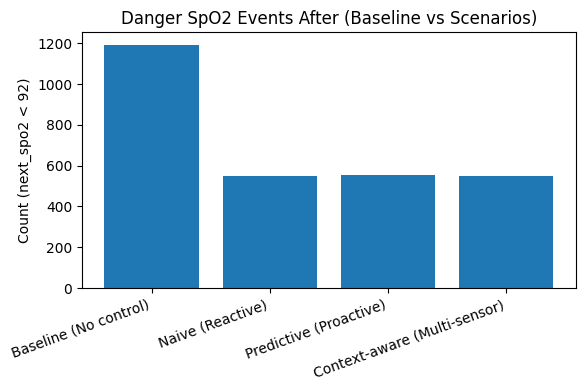

In [8]:
plt.figure(figsize=(6,4))
plt.bar(summary.index, summary["spo2_danger_count_after"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("Count (next_spo2 < 92)")
plt.title("Danger SpO2 Events After (Baseline vs Scenarios)")
plt.tight_layout()
plt.show()

시각화 2: HR 안정화 비교

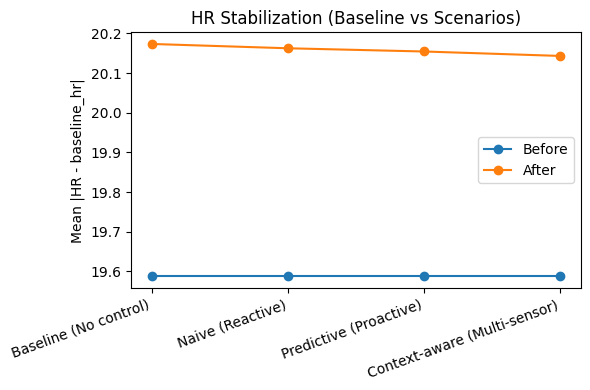

In [9]:
plt.figure(figsize=(6,4))
plt.plot(summary.index, summary["avg_hr_error_before"], marker="o", label="Before")
plt.plot(summary.index, summary["avg_hr_error_after"], marker="o", label="After")
plt.xticks(rotation=20, ha="right")
plt.ylabel("Mean |HR - baseline_hr|")
plt.title("HR Stabilization (Baseline vs Scenarios)")
plt.legend()
plt.tight_layout()
plt.show()

결론

In [10]:
best_spo2 = summary["spo2_danger_count_after"].idxmin()
best_hr   = summary["avg_hr_error_after"].idxmin()

best_spo2, best_hr

('Naive (Reactive)', 'Context-aware (Multi-sensor)')

의료 IoT 시나리오 분석 결과, 사후 대응(Naive) 및 예측 기반 개입(Predictive)은 
SpO₂ 위험 이벤트 발생 횟수를 baseline 대비 약 50% 이상 감소시켰으며, 
특히 다중 센서를 활용한 context-aware 시나리오는 심박 변화량(ramp)을 가장 효과적으로 완화하였다. 
이는 예측 기반 EMS 개념이 의료 IoT 환경에서도 안정성 향상에 기여할 수 있음을 시사한다.